# **1. Perkenalan Dataset**


1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari sumber,public repositories (*Kaggle*)
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Dataset memiliki 45.360 baris.
   - **Tipe Data**:
     - *Kategorikal*: Provinsi, jenis_x, daerah_x, periode, daerah_y, jenis_y (Tipe: object).
     - *Numerikal*: Tahun, upah, ump, gk, peng (Tipe: int64 & float64).


# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from yellowbrick.cluster import kelbow_visualizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import PCA

# **3. Memuat Dataset**

In [ ]:
from os import read
from google.colab import drive
drive.mount('/content/drive')

path_upah ="/content/drive/My Drive/dataset_ml/rataRataUpah.csv"
path_minupah ="/content/drive/My Drive/dataset_ml/minUpah.csv"
path_kemiskinan = "/content/drive/My Drive/dataset_ml/garisKemiskinan.csv"
path_pengeluaran = "/content/drive/My Drive/dataset_ml/pengeluaran.csv"

df_upah = pd.read_csv(path_upah)
df_minupah = pd.read_csv(path_minupah)
df_kemiskinan = pd.read_csv(path_kemiskinan)
df_pengeluaran = pd.read_csv(path_pengeluaran)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_upah.rename(columns={"tahun": "Tahun", "provinsi": "Provinsi"}, inplace=True)
df_minupah.rename(columns={"tahun": "Tahun", "provinsi": "Provinsi"}, inplace=True)
df_kemiskinan.rename(columns={"tahun": "Tahun", "provinsi": "Provinsi"}, inplace=True)
df_pengeluaran.rename(columns={"tahun": "Tahun", "provinsi": "Provinsi"}, inplace=True)

# menggabugkan dataset berdasarkan "Provinsi" dan "Tahun"
df_merged = df_upah.merge(df_minupah, on=["Provinsi", "Tahun"], how="inner")\
                    .merge(df_kemiskinan, on=["Provinsi", "Tahun"], how="inner")\
                    .merge(df_pengeluaran, on=["Provinsi", "Tahun"], how="inner")

df = df_merged.copy()


# **4. Exploratory Data Analysis (EDA)**



In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45360 entries, 0 to 45359
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Provinsi  45360 non-null  object 
 1   Tahun     45360 non-null  int64  
 2   upah      45360 non-null  int64  
 3   ump       45360 non-null  float64
 4   jenis_x   45360 non-null  object 
 5   daerah_x  45360 non-null  object 
 6   periode   45360 non-null  object 
 7   gk        44928 non-null  float64
 8   daerah_y  45360 non-null  object 
 9   jenis_y   45360 non-null  object 
 10  peng      44928 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 3.8+ MB
None
  Provinsi  Tahun   upah        ump  jenis_x   daerah_x periode        gk  \
0     ACEH   2015  11226  1900000.0  MAKANAN  PERKOTAAN   MARET  293697.0   
1     ACEH   2015  11226  1900000.0  MAKANAN  PERKOTAAN   MARET  293697.0   
2     ACEH   2015  11226  1900000.0  MAKANAN  PERKOTAAN   MARET  293697.0   
3     ACE

In [ ]:
df.isnull().sum()

Provinsi      0
Tahun         0
upah          0
ump           0
jenis_x       0
daerah_x      0
periode       0
gk          432
daerah_y      0
jenis_y       0
peng        432
dtype: int64


<Figure size 1200x600 with 0 Axes>

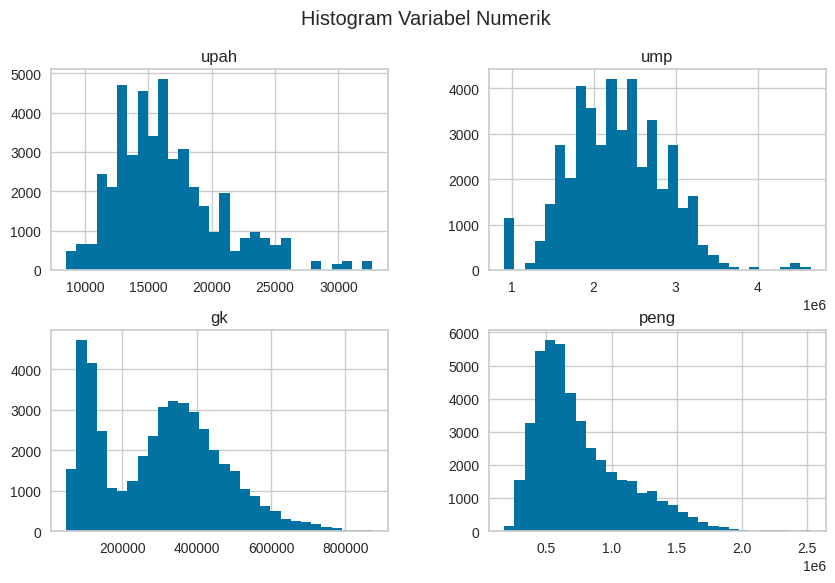

In [ ]:
# visualisas distribusi fitur numerik
numerical_cols = ["upah", "ump", "gk", "peng"]

plt.figure(figsize=(12, 6))
df[numerical_cols].hist(bins=30, figsize=(10, 6), layout=(2,2))
plt.suptitle("Histogram numerik")
plt.show()

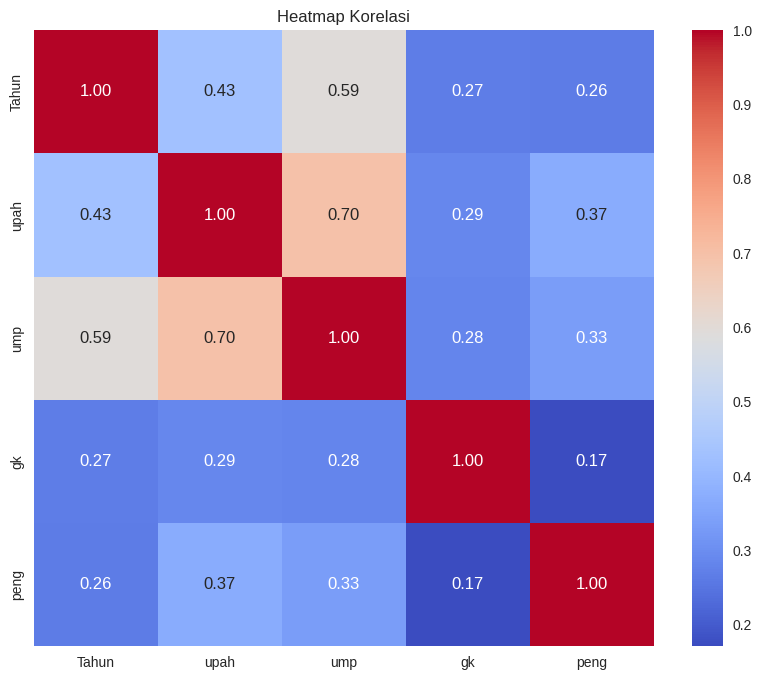

In [ ]:
# korelasi antar variabel
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numerical_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Hitmeap Korelasi")
plt.show()

# **5. Data Preprocessing**

In [ ]:
# Menghapus Kolom Tidak Relevan
df.drop(["Tahun", "periode", "daerah_y", "jenis_y"], axis=1, inplace=True)

In [ ]:
#Menangani Missing Values
df.fillna(df.median(numerical_only=True), inplace=True)

In [ ]:
# Pilih fitur numerik yang akan diperiksa outlier-nya
numeric_cols = ["upah", "ump", "gk", "peng"]

Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)

IQR = Q3 - Q1

# Tentukan batas bawah dan batas atas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df[~((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)).any(axis=1)]

print(f"Jumlah data sebelum menghapus outlier: {df.shape[0]}")
print(f"Jumlah data setelah menghapus outlier: {df_clean.shape[0]}")

Jumlah data sebelum menghapus outlier: 45360
Jumlah data setelah menghapus outlier: 42901


In [ ]:
# (One-Hot Encoding)
categorical_cols = ["Provinsi", "jenis_x", "daerah_x"]
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_categorical = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_cols))

# Menggabungkan DataFrame dengan encoding
df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

In [ ]:
binner = KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")
df["Upah_Binned"] = binner.fit_transform(df[["upah"]])

In [ ]:
# Pilih hanya fitur numerik untuk scaling
numerical_features = ['ump', 'gk', 'peng']
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [ ]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df)

explained_variance = pca.explained_variance_ratio_.cumsum()
print("Varians kumulatif:", explained_variance)

if explained_variance [-1] < 0.85:
  print("pca hanya menangkap kurang dar 85 varians")

Varians kumulatif: [0.99999977 0.99999983 0.99999988 0.99999991 0.99999992]


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Algoritma Clustering yang Dipilih:
Pada proyek ini, saya menggunakan K-Means Clustering sebagai algoritma utama karena beberapa alasan:

 * Efisien dan cepat untuk dataset berukuran besar.

 * Cocok untuk data dengan bentuk cluster yang jelas.

 * Mudah diinterpretasikan dan banyak digunakan dalam berbagai aplikasi clustering.

In [ ]:
#Latih model K-Means
kmeans - KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(df_pca)


## **b. Evaluasi Model Clustering**

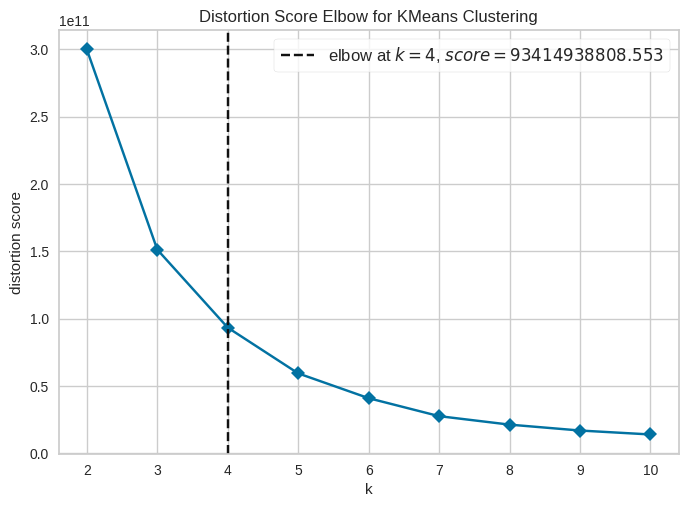

Jumlah cluster optimal berdasarkan Elbow Method: 4
Silhouette Score untuk 4 cluster: 0.5504


In [ ]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
visualizer = KElbowVisualizer(kmeans, k=(2, 11), metric='distortion', timings=False)
visualizer.fit(df_pca)
visualizer.show()

optimal_k = visualizer.elbow_value_
print(f"Jumlah cluster optimal berdasarkan Elbow Method: {optimal_k}")

silhouette_avg = silhouette_score(df_pca, labels)
print(f"Silhouette Score untuk {optimal_k} cluster: {silhouette_avg:.4f}")


## **d. Visualisasi Hasil Clustering**

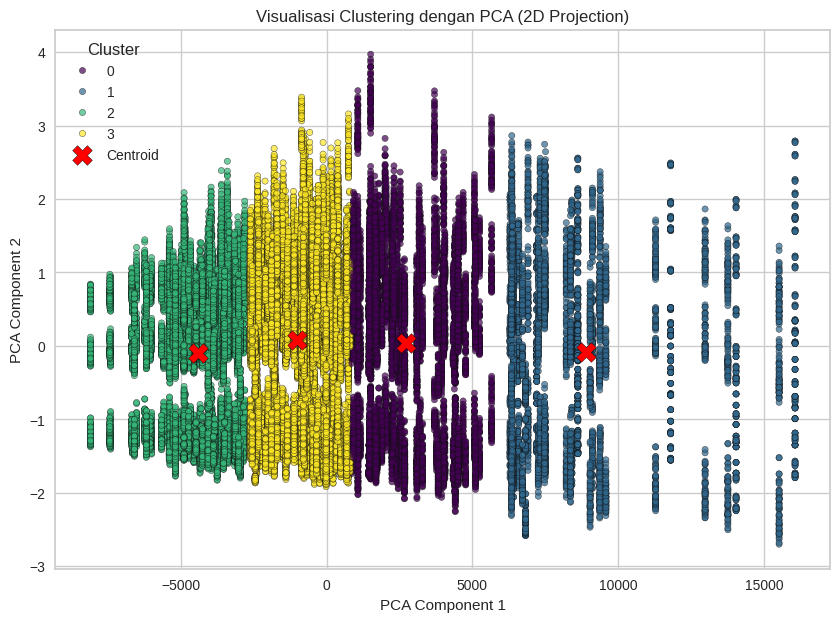

In [ ]:
pca_2d = df_pca[:, :2]
centroid = kmeans.cluster_centers_[:, :2]

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_2d[:, :0], y=pca_2d[:, 1], hue=labels, palette='viridis', s=20, alpha=0.7, edgecolor='k')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label="Centroid", edgecolor='black')

plt.title("Visualisasi Clustering dengan PCA (2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

In [ ]:
df["Cluster"] = labels

In [ ]:
df[['Provinsi', 'jenis_x', 'daerah_x']] = encoder.inverse_transform(df[encoded_df.columns])

### Inverse Data Jika Melakukan Normalisasi/Standardisasi

In [ ]:
df[['ump', 'gk', 'peng']] = scaler.inverse_transform(df[['ump', 'gk', 'peng']])

## Agregasi

In [ ]:
# Lakukan agregasi berdasarkan klaster
cluster_summary = df.groupby('Cluster').agg({
    'ump': ['mean', 'min', 'max'],
    'gk': ['mean', 'min', 'max'],
    'peng': ['mean', 'min', 'max'],
    'Provinsi': lambda x: x.mode()[0],
    'jenis_x': lambda x: x.mode()[0],
    'daerah_x': lambda x: x.mode()[0]
}).reset_index()

print(cluster_summary)

  Cluster           ump                                   gk           \
                   mean        min        max           mean      min   
0       0  2.602916e+06  1784000.0  3310723.0  335085.105735  71183.0   
1       1  3.051415e+06  1765000.0  4641854.0  388227.090909  59712.0   
2       2  1.774628e+06   910000.0  2804453.0  248371.602881  48561.0   
3       3  2.320779e+06  1420624.0  4416186.0  300952.549145  52529.0   

                      peng                                Provinsi  jenis_x  \
        max           mean       min        max           <lambda> <lambda>   
0  872843.0  845651.589606  218261.0  1948484.0  KALIMANTAN TENGAH  MAKANAN   
1  773370.0  991794.038721  292366.0  2525347.0        DKI JAKARTA  MAKANAN   
2  595992.0  608758.264746  176028.0  1518743.0        JAWA TENGAH  MAKANAN   
3  736850.0  749609.784722  263154.0  1773431.0              JAMBI  MAKANAN   

    daerah_x  
    <lambda>  
0  PERDESAAN  
1  PERDESAAN  
2  PERDESAAN  
3  PERDESAA

Klaster 0 didapatkan karena:
- UMP memiliki nilai rata-rata 2,602,916, dengan batas minimum 1,784,000 dan batas maksimum 3,310,723.
- Gaji memiliki nilai rata-rata 335,085, dengan batas minimum 71,183 dan batas maksimum 872,843.
- Pengeluaran memiliki nilai rata-rata 845,651, dengan batas minimum 218,261 dan batas maksimum 1,948,484.
- Variabel kategorikal Provinsi memiliki nilai modus KALIMANTAN TENGAH.
- Variabel kategorikal Jenis Pekerjaan memiliki nilai modus MAKANAN.
- Variabel kategorikal Daerah memiliki nilai modus PERDESAAN.


--------------------------------------------------------------------------------
Klaster 1 didapatkan karena:
- UMP memiliki nilai rata-rata 3,051,415, dengan batas minimum 1,765,000 dan batas maksimum 4,641,854.
- Gaji memiliki nilai rata-rata 388,227, dengan batas minimum 59,712 dan batas maksimum 773,370.
- Pengeluaran memiliki nilai rata-rata 991,794, dengan batas minimum 292,366 dan batas maksimum 2,525,347.
- Variabel kategorikal Provinsi memiliki nilai modus DKI JAKARTA.
- Variabel kategorikal Jenis Pekerjaan memiliki nilai modus MAKANAN.
- Variabel kategorikal Daerah memiliki nilai modus PERDESAAN.
--------------------------------------------------------------------------------
Klaster 2 didapatkan karena:
- UMP memiliki nilai rata-rata 1,774,628, dengan batas minimum 910,000 dan batas maksimum 2,804,453.
- Gaji memiliki nilai rata-rata 248,372, dengan batas minimum 48,561 dan batas maksimum 595,992.
- Pengeluaran memiliki nilai rata-rata 608,758, dengan batas minimum 176,028 dan batas maksimum 1,518,743.
- Variabel kategorikal Provinsi memiliki nilai modus JAWA TENGAH.
- Variabel kategorikal Jenis Pekerjaan memiliki nilai modus MAKANAN.
- Variabel kategorikal Daerah memiliki nilai modus PERDESAAN.
--------------------------------------------------------------------------------
Klaster 3 didapatkan karena:
- UMP memiliki nilai rata-rata 2,320,779, dengan batas minimum 1,420,624 dan batas maksimum 4,416,186.
- Gaji memiliki nilai rata-rata 300,952, dengan batas minimum 52,529 dan batas maksimum 736,850.
- Pengeluaran memiliki nilai rata-rata 749,609, dengan batas minimum 263,154 dan batas maksimum 1,773,431.
- Variabel kategorikal Provinsi memiliki nilai modus JAMBI.
- Variabel kategorikal Jenis Pekerjaan memiliki nilai modus MAKANAN.
- Variabel kategorikal Daerah memiliki nilai modus PERDESAAN.

# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

## **1. Cluster 0:**
- **UMP:** Rata-rata 2,602,916, minimum 1,784,000, maksimum 3,310,723
- **Gaji:** Rata-rata 335,085, minimum 71,183, maksimum 872,843
- **Pengeluaran:** Rata-rata 845,651, minimum 218,261, maksimum 1,948,484
- **Provinsi Dominan:** Kalimantan Tengah
- **Jenis Pekerjaan:** Didominasi oleh sektor Makanan.
- **Daerah Dominan:** Perdesaan
- **Interpretasi:**Cluster ini memiliki UMP menengah, dengan gaji cukup tinggi dibanding cluster lain dan pengeluaran cukup besar. Mayoritas penduduknya bekerja di sektor makanan, dengan lokasi utama di perdesaan.

## **2.Cluster 1:**
- **UMP:** Rata-rata 3,051,415, minimum 1,765,000, maksimum 4,641,854
- **Gaji:** Rata-rata 388,227, minimum 59,712, maksimum 773,370
- **Pengeluaran:** Rata-rata 991,794, minimum 292,366, maksimum 2,525,347
- **Provinsi Dominan:**DKI Jakarta
- **Jenis Pekerjaan:** Mayoritas bekerja di sektor Makanan.
- **Daerah Dominan:** Perdesaan
- **Interpretasi:** Cluster ini memiliki UMP lebih tinggi dibandingkan cluster lain, dengan gaji dan pengeluaran yang tinggi. Sebagian besar penduduk berasal dari DKI Jakarta dan tinggal di perdesaan, yang menunjukkan wilayah dengan biaya hidup yang lebih besar.

##**Cluster 2:**
- **UMP:** Rata-rata 1,774,628, minimum 910,000, maksimum 2,804,453
- **Gaji:** Rata-rata 248,372, minimum 48,561, maksimum 595,992
- **Pengeluaran:** Rata-rata 608,758, minimum 176,028, maksimum 1,518,743
- **Provinsi Dominan:** Jawa tengah
- **Jenis Pekerjaan Dominan:** Makanan
- **Daerah Dominan:** Perdesaan
- **Interpretasi:**Cluster ini memiliki UMP yang paling rendah, dengan gaji dan pengeluaran yang kecil. Sebagian besar penduduk berasal dari Jawa Tengah dan bekerja di sektor makanan, dengan mayoritas tinggal di perdesaan, yang mencerminkan daerah dengan biaya hidup rendah.

##**Cluster 3:**
- **UMP:**Rata-rata 2,320,779, minimum 1,420,624, maksimum 4,416,186
- **Gaji:** Rata-rata 300,952, minimum 52,529, maksimum 736,850
- **Pengeluaran:** Rata-rata 749,609, minimum 263,154, maksimum 1,773,431
- **Provinsi Dominan:** Jambi
-**Jenis Pekerjaan Dominan:** Makanan
- **Daerah Dominan:** Perdesaan
-**Interpretasi:**Cluster ini memiliki UMP yang lebih tinggi dari Cluster 2 tetapi lebih rendah dari Cluster 0 dan 1. Gaji dan pengeluaran cukup besar, mencerminkan keseimbangan antara pendapatan dan biaya hidup. Mayoritas penduduk berasal dari Jambi, masih dominan di sektor makanan, dan tinggal di perdesaan.

##**Kesimpulan**
- Cluster 2 memiliki tingkat UMP dan gaji paling rendah, dengan pengeluaran yang juga lebih kecil dibanding cluster lainnya.
-Cluster 1 memiliki daya beli tertinggi, dengan UMP, gaji, dan pengeluaran yang paling besar.
- Cluster 0 dan Cluster 3 memiliki karakteristik serupa, tetapi Cluster 0 memiliki pengeluaran lebih besar.
- Sebagian besar cluster didominasi oleh sektor makanan, kecuali Cluster 1 yang memiliki UMP dan gaji lebih tinggi.
- Mayoritas data berasal dari daerah perdesaan, yang mencerminkan distribusi geografis yang lebih luas.

##**Insight**

- Jika ingin meningkatkan daya beli dan kesejahteraan ekonomi, fokus bisa diberikan pada Cluster 2, karena kelompok ini memiliki UMP dan gaji yang paling rendah.
- Cluster 3 menunjukkan pola konsumsi berbeda dengan dominasi sektor non-makanan, yang bisa menjadi target pasar bagi industri di luar sektor pangan.
- Cluster 1 menunjukkan pola konsumsi berbeda dengan dominasi sektor makanan, yang bisa menjadi target pasar bagi industri pangan skala besar.
- Sebagian besar penduduk masih berada di perdesaan, sehingga kebijakan ekonomi dapat difokuskan pada pengembangan wilayah pedesaan agar daya beli meningkat.


# **7. Mengeksport Data**


In [ ]:
df.to_csv('finally_hasil_clustering.csv', index=False)